# Readme first 

**Acknowledgements:**
The idea of the processing was inspired by *MEDIUM* post which was here:
https://medium.com/@andrewtan_36013/principal-components-of-electrocardiograms-14874b3a96b1

Base-line removing is based on `mitbal/py-bwr` project, by we used its fork `spebern/py-bwr`. This repository doesn't have a release, so I archived it into `data/py-bwr-3552795298b343a42d38d5a33a9f302af3d1db4c.tar.gz` in case if the repository will be removed by the author.

**Setting up environment:**

That are all required packages:
`pip3 install scikit-learn pandas matplotlib scipy neurokit2 ipympl requests PyWavelets`

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import neurokit2 as nk
from ecgfuns import *
# simple lambda-comprehension
remove_nans = lambda x: [i for i in x if not pd.isna(i)]

In [2]:
%%bash

if [ ! -d "./py-bwr" ]; then
    # Run your console command here
    git clone https://github.com/spebern/py-bwr
else
    echo "Baseline remover have already been synchronized!"
fi

Baseline remover have already been synchronized!


In [3]:
import sys
sys.path.append('./py-bwr/')
import bwr

~

**Let's analyze thermogenetically transformed mouse hearts..**

Here we use the same example data that were published in our Zenodo ECG repository:
https://zenodo.org/records/8346874

# Sample 122 (commented)

In [4]:
# read the data
a = pd.read_csv('./data/peaks_data_122.csv.gz')
a.head()

,Time_s,Laser_V,ECG_ch1,Las_peaks,ECG_peaks
0,0.0000,-0.00200,0.0,NaN,NaN
1,0.0001,-0.00200,0.0,NaN,NaN
2,0.0002,-0.00157,0.0,NaN,NaN
3,0.0003,-0.00157,0.0,NaN,NaN
4,0.0004,-0.00242,0.0,NaN,NaN


In [5]:
# subtract baseline
bl = bwr.calc_baseline( a.ECG_ch1.to_numpy() )
a['ch1_bc'] = 0.00
a.loc[:,'ch1_bc'] = a.ECG_ch1.to_numpy() - bl

a.head()

,Time_s,Laser_V,ECG_ch1,Las_peaks,ECG_peaks,ch1_bc
0,0.0000,-0.00200,0.0,NaN,NaN,0.009622
1,0.0001,-0.00200,0.0,NaN,NaN,0.009717
2,0.0002,-0.00157,0.0,NaN,NaN,0.009812
3,0.0003,-0.00157,0.0,NaN,NaN,0.009908
4,0.0004,-0.00242,0.0,NaN,NaN,0.010005


In [6]:
# add PCA-filtered data of original and baseline-corrected values
b = addFilteredDataE(a, 'ch1_bc', comps=3)
b = addFilteredDataE(b, 'ECG_ch1', comps=3)

Mean len of RR interval:  1999
Mean len of RR interval:  2292
Mean len of RR interval:  1999
Mean len of RR interval:  2292


## Demonstrate result of filtration

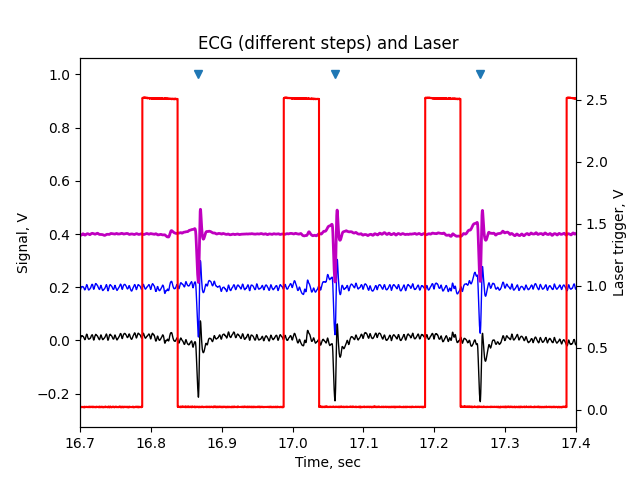

In [17]:
%matplotlib widget
fig1 = plt.figure(num=1)
fig1.clear()
plt.title('ECG (different steps) and Laser')
plt.plot(b["Time_s"], -b.ECG_ch1, '-k', lw=1, alpha=1)
plt.plot(b["Time_s"], -b.ch1_bc+.2, '-b', lw=1, alpha=1)
plt.plot(b["Time_s"], -b.ch1_bc_dns+.4, '-m', lw=2, alpha=1)
plt.plot(b["Time_s"], b.ECG_peaks, 'v', lw=2, alpha=1)
plt.ylabel('Signal, V')
plt.xlabel('Time, sec')
plt.twinx()
plt.plot(b["Time_s"], b.Laser_V, '-r', alpha=1)
plt.xlim(16.7, 17.4)
plt.ylabel('Laser trigger, V')
plt.show()

## Check R-peak detection

In [8]:
# note, that you should not put real sampling rate here because
# neurokit lab is adjusted for human ECGs, so it doesn't understands peaks 
# which are very close to each other. But mice ECG is much faster, so 
# we imitate slower ECG by setting lower sampling rate here

_, rpeaks = nk.ecg_peaks(-b.ch1_bc_dns, sampling_rate=5000)

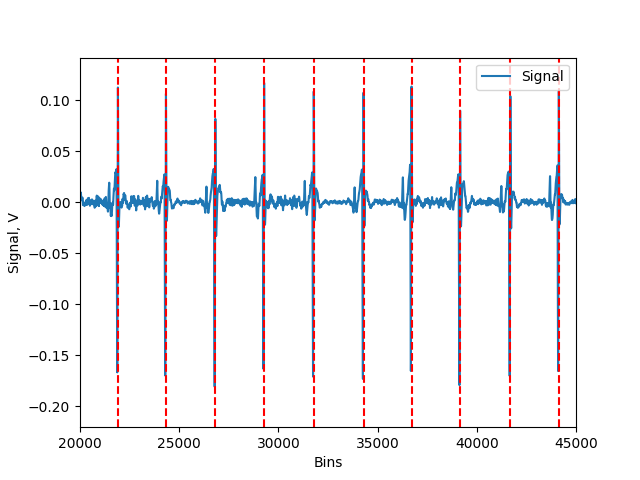

In [18]:
# here one should manually inspect the quality of automatic ECG segmentation

%matplotlib widget
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], -b.ch1_bc_dns)
plt.xlim(20000, 45000)
plt.xlabel('Bins')
plt.ylabel('Signal, V')
plt.show()

## Check P-peak detection

In [10]:
# Delineate the ECG signal, detect P-peaks
_, waves_peak = nk.ecg_delineate(-b.ECG_ch1_dns, rpeaks, sampling_rate=5000, method="cwt")

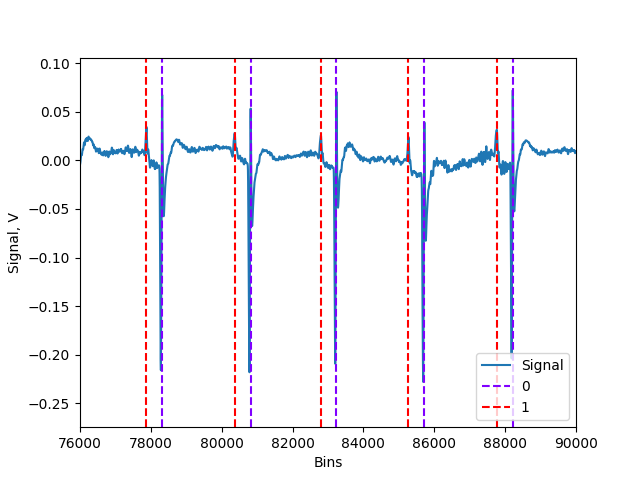

In [19]:
%matplotlib widget
# check if P-peaks are annotated correctly
# it maybe worth scanning ECG forward and backward to inspect
plot = nk.events_plot([rpeaks['ECG_R_Peaks'], 
                       waves_peak['ECG_P_Peaks']], -b.ECG_ch1_dns)
plt.xlabel('Bins')
plt.ylabel('Signal, V')
plt.xlim(76000, 90000)
plt.show()

## Draw phasic plots

In [12]:
# extract indices where P-peak is determined
# fill P_peaks column with 1 or nans
ppks = remove_nans(waves_peak['ECG_P_Peaks'])
b['P_peaks'] = np.nan
b.loc[ppks, 'P_peaks'] = 1

**Code for Polar plot.** Radius stands for a beat, angle is a phase inside R-R interval.

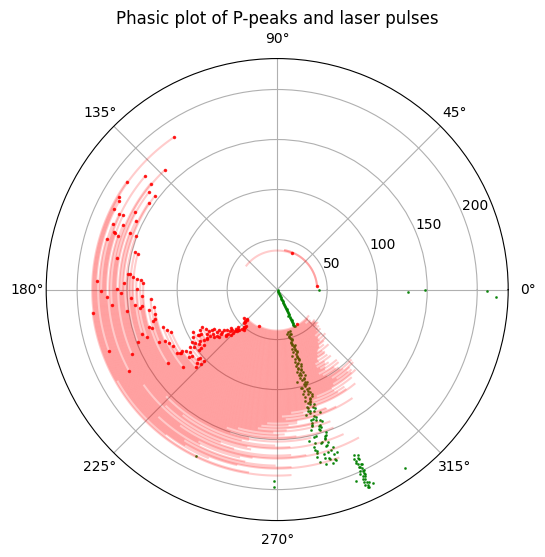

In [22]:
%matplotlib inline
rads = genPhaseData(b, rpeaks['ECG_R_Peaks'] ) #b.query('ECG_peaks == 1').index.tolist()

fig = plt.figure(num=5, figsize = (6, 6))
plt.axes(projection='polar')    

p4p = rads.query('type == "p"')

plt.polar(p4p.phase/180*np.pi, p4p.i, 'go', ms=1, alpha = 0.8)

l4p = rads.query('type == "laser"')

plt.polar(l4p.phase/180*np.pi, l4p.i, 'ro', ms=1.5, alpha = 0.8)

e4p = rads.query('type == "lasend"')
for i in l4p.i:
    thb = l4p.query('i == '+str(i)).iloc[0,2]
    the = e4p.query('i =='+str(i)).iloc[0,2]
    plt.polar(np.linspace(thb, the, 100)/180*np.pi, [i]*100, 'r-', ms=1.5, alpha = 0.2)

_ = plt.title('Phasic plot of P-peaks and laser pulses')

In [14]:
# Plotting is based on genPhaseData function 
# this function read previously processed and segmented data and return the following table,
# which is very easy to plot;
# we have there *i* - for event number, *type* - for event type, 
#   *phase* - for the phase of event inside R-R interval (in degrees) and 
#   *period* - for corresponding R-R interval length (in ms)
# that is the snapshot of the table
rads.head()

,i,type,phase,period
0,1,p,-0.144231,249.6
1,2,p,-65.039620,252.4
2,3,p,-65.135903,246.5
3,4,p,-65.322581,248.0
4,5,p,-65.012285,244.2


**Code for decart plot.** Meaning of values are the same.

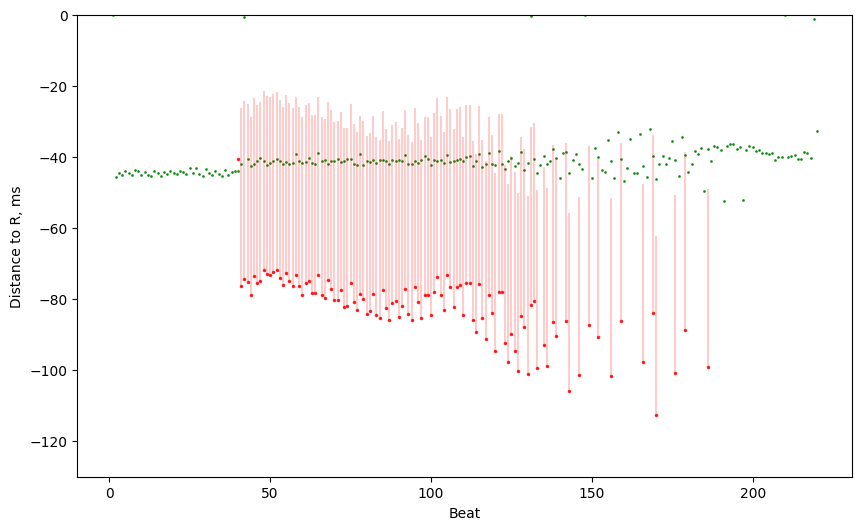

In [15]:
%matplotlib inline
fig = plt.figure(figsize = (10, 6))
plt.axes()    

p4p = rads.query('type == "p"')

plt.plot(p4p.i, p4p.phase/360*p4p.period, 'go', ms=1, alpha = 0.8)

l4p = rads.query('type == "laser"')

plt.plot(l4p.i, l4p.phase/360*l4p.period, 'ro', ms=1.5, alpha = 0.8)

e4p = rads.query('type == "lasend"')
for i in l4p.i:
    thb = l4p.query('i == '+str(i)).iloc[0,2]
    the = e4p.query('i =='+str(i)).iloc[0,2]
    period = l4p.query('i == '+str(i)).iloc[0].period
    plt.plot([i]*100, np.linspace(thb, the, 100)/360*period, 'r-', ms=1.5, alpha = 0.2)
_ = plt.ylim(-130, 0)
_ = plt.ylabel('Distance to R, ms')
_ = plt.xlabel('Beat')
plt.show()

## Hear rate measurements

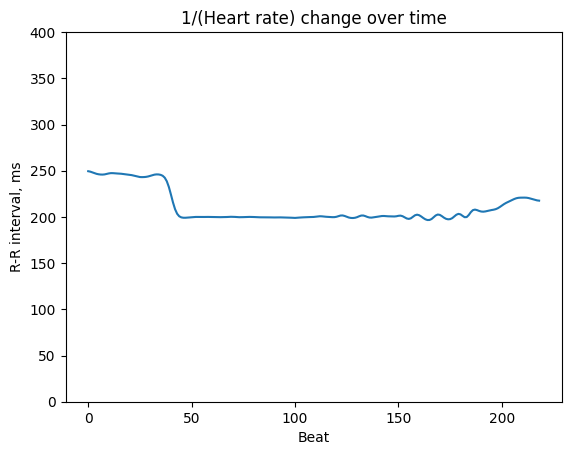

In [16]:
%matplotlib inline
plt.plot( gaussian_filter1d(rads.query('type == "p"').period, sigma=2) )
plt.ylim(0,400)
plt.ylabel('R-R interval, ms')
plt.xlabel('Beat')
plt.title('1/(Heart rate) change over time')
plt.show()